# PSMC Demographic Reconstruction

This notebook implements demographic history reconstruction using PSMC (Pairwise Sequentially Markovian Coalescent).




In [16]:
import yaml
from pathlib import Path

def load_config():
    # Use absolute path to the config file
    config_path = Path("/Users/divyadhole/Capstone-project/config.yaml")
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        print("✅ Config file loaded successfully!")
        return config
    except Exception as e:
        print(f"❌ Error loading config file: {e}")
        return None

# Load the config
config = load_config()
if config:
    # Create full paths by joining with project root
    VCF_DIR = Path(config['project_root']) / config['vcf_dir']
    print(f"VCF directory: {VCF_DIR}")
    
    # Example of using other paths
    OUTPUT_DIR = Path(config['project_root']) / config['output_dir']
    print(f"Output directory: {OUTPUT_DIR}")

✅ Config file loaded successfully!
VCF directory: /Users/divyadhole/Capstone-project/data/VCF_files
Output directory: /Users/divyadhole/Capstone-project/outputs


## Step 1: – FASTA ➜ PSMC input


In [20]:
from pathlib import Path

# Define project root
PROJECT_ROOT = Path("/Users/divyadhole/Capstone-project")

# Load config
with open(PROJECT_ROOT / "config.yaml", 'r') as f:
    config = yaml.safe_load(f)

# Get genome file path
GENOME_FILE = PROJECT_ROOT / config.get('genome_file', 'data/reference/genome.fasta')

# Check if genome file exists
if not GENOME_FILE.exists():
    print(f"❌ Error: Genome file not found at {GENOME_FILE}")
    print("Please ensure the file exists or update the 'genome_file' path in config.yaml")
else:
    print(f"✅ Genome file found at: {GENOME_FILE}")
    print(f"File size: {GENOME_FILE.stat().st_size / (1024*1024):.2f} MB")

✅ Genome file found at: /Users/divyadhole/Capstone-project/data/reference/Rhinopithecus_roxellana-001.fasta
File size: 2934.25 MB


In [23]:
import re
from pathlib import Path
from Bio import SeqIO
import yaml

def load_config():
    """Load configuration from YAML file."""
    config_path = Path("/Users/divyadhole/Capstone-project/config.yaml")
    try:
        with open(config_path, 'r') as f:
            return yaml.safe_load(f)
    except Exception as e:
        raise RuntimeError(f"Error loading config: {e}")

def fasta_to_psmc_input(fasta_file, output_file, sample_name="sample"):
    """Convert FASTA genome to the consensus format PSMC expects."""
    try:
        sequences = []
        for record in SeqIO.parse(str(fasta_file), "fasta"):
            seq = str(record.seq).upper()
            seq = re.sub(r"[^ATCG]", "N", seq)  # Replace non-ATCG with N
            sequences.append((record.id, seq))

        with open(output_file, "w") as handle:
            handle.write(f">{sample_name}\n")
            for _, seq in sequences:
                for i in range(0, len(seq), 60):
                    handle.write(seq[i:i+60] + "\n")
        print(f"✅ Successfully converted {fasta_file} to PSMC format: {output_file}")
        return True
        
    except Exception as e:
        print(f"❌ Error converting FASTA to PSMC format: {e}")
        return False

def resolve_genome_path(config):
    """Resolve the genome file path from config."""
    try:
        genome_path = Path(config.get("genome_file", ""))
        if not genome_path.is_absolute():
            project_root = Path("/Users/divyadhole/Capstone-project")
            genome_path = (project_root / genome_path).resolve()
        return genome_path
    except Exception as e:
        raise RuntimeError(f"Error resolving genome path: {e}")

def main():
    # Load configuration
    try:
        config = load_config()
        OUTPUT_DIR = Path("/Users/divyadhole/Capstone-project/outputs")
        OUTPUT_DIR.mkdir(exist_ok=True)
        
        # Resolve genome file path
        GENOME_FILE = resolve_genome_path(config)
        PSMC_INPUT = OUTPUT_DIR / "psmc_input.txt"
        
        # Process genome file
        if not GENOME_FILE.exists():
            raise FileNotFoundError(
                f"Genome file not found at {GENOME_FILE}\n"
                "Please ensure the file exists or update 'genome_file' in config.yaml"
            )
            
        print(f"🔍 Found genome file: {GENOME_FILE}")
        
        # Convert to PSMC format
        if fasta_to_psmc_input(GENOME_FILE, PSMC_INPUT, sample_name="sample1"):
            print(f"✅ PSMC input file created: {PSMC_INPUT}")
            print(f"File size: {PSMC_INPUT.stat().st_size / (1024*1024):.2f} MB")
            
    except Exception as e:
        print(f"❌ Error: {e}")
        return False
    return True

if __name__ == "__main__":
    main()

🔍 Found genome file: /Users/divyadhole/Capstone-project/data/reference/Rhinopithecus_roxellana-001.fasta
✅ Successfully converted /Users/divyadhole/Capstone-project/data/reference/Rhinopithecus_roxellana-001.fasta to PSMC format: /Users/divyadhole/Capstone-project/outputs/psmc_input.txt
✅ PSMC input file created: /Users/divyadhole/Capstone-project/outputs/psmc_input.txt
File size: 2946.00 MB


## Step 2: Run PSMC analysis


In [37]:
def run_psmc(input_file, output_file, params=None):
    if params is None:
        params = config.get('psmc_params', {})

    cmd = ['psmc']
    for key, value in params.items():
        cmd.extend([key, str(value)])
    cmd.extend(['-o', str(output_file), str(input_file)])

    print(f"Running PSMC: {' '.join(cmd)}")
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"PSMC error: {result.stderr}")
        raise RuntimeError("PSMC failed")

    print(f"PSMC completed: {output_file}")
    return output_file

PSMC_OUTPUT = OUTPUT_DIR / "psmc_output.psmc"

if PSMC_INPUT.exists():
    run_psmc(PSMC_INPUT, PSMC_OUTPUT)
else:
    print("PSMC input file not found. Run Step 1 first.")

Running PSMC: psmc N 25 t 15 r 5 p 4+25*2+4+6 -o outputs/psmc_output.psmc /Users/divyadhole/Capstone-project/outputs/psmc_input.txt
PSMC completed: outputs/psmc_output.psmc


## Step 3: Parse PSMC output


In [25]:
def parse_psmc_output(psmc_file, mu=2.5e-8, genome_length=1e9, generation_time=25):
    """
    Parses RS lines from the PSMC output and estimates Ne assuming:
      - mu: mutation rate per site per generation
      - genome_length: callable genome length
      - generation_time: years per generation
    """
    time_points = []
    ne_values = []

    with open(psmc_file, 'r') as f:
        for line in f:
            if line.startswith('RS'):
                parts = line.strip().split('\t')
                # Format: RS\tk\tleft_time\tlambda_k\ttheta_k
                if len(parts) >= 5:
                    time_k = float(parts[2])
                    lambda_k = float(parts[3])
                    # theta_k = parts[4] but we only need lambda here

                    if mu > 0 and genome_length > 0:
                        ne = lambda_k / (4 * mu * genome_length)
                    else:
                        ne = lambda_k

                    time_points.append(time_k)
                    ne_values.append(ne)

    df = pd.DataFrame({
        "time_generations": time_points,
        "Ne": ne_values,
        "time_years": [t * 2 * generation_time for t in time_points]
    })
    return df

if PSMC_OUTPUT.exists():
    psmc_results = parse_psmc_output(PSMC_OUTPUT)
    psmc_results.to_csv(OUTPUT_DIR / "psmc_results.csv", index=False)
    print("PSMC results parsed successfully!")
    display(psmc_results.head())
else:
    print("PSMC output file not found. Run Step 2 first.")

PSMC results parsed successfully!


,time_generations,Ne,time_years
0,0.000000,0.01,0.00000
1,0.025616,0.01,1.28080
2,0.057793,0.01,2.88965
3,0.098213,0.01,4.91065
4,0.148988,0.01,7.44940


## Step 4: Visualize demographic history


Saved plot: /Users/divyadhole/Capstone-project/outputs/demographic_history.png


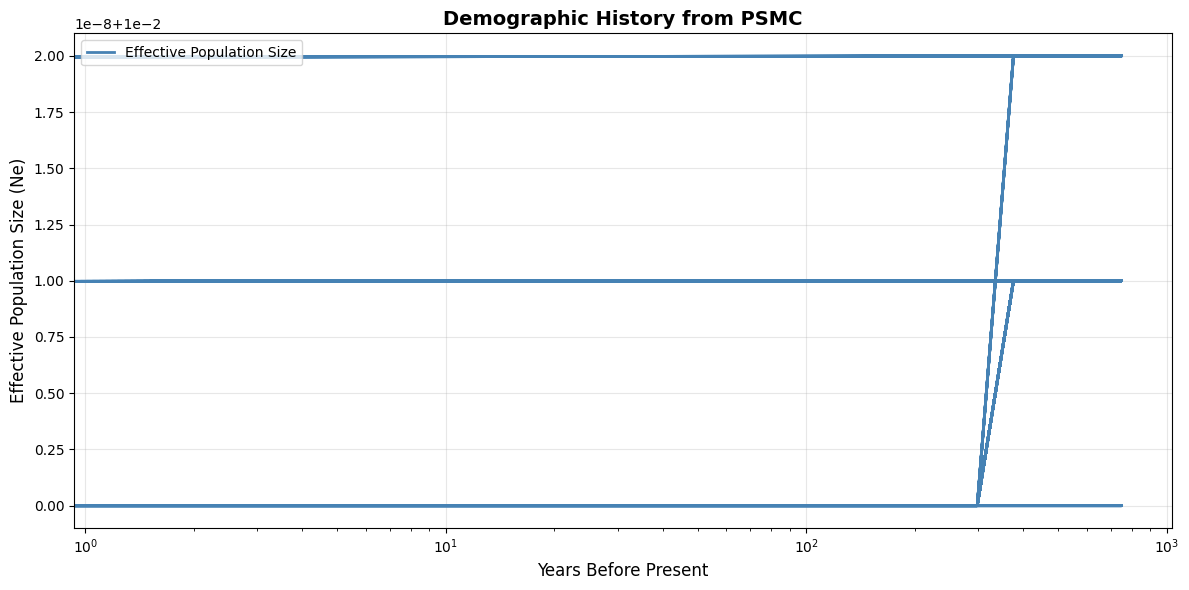


PSMC analysis complete!


In [26]:
def plot_demographic_history(psmc_df, output_file=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.semilogx(psmc_df["time_years"], psmc_df["Ne"],
                linewidth=2, color="steelblue",
                label="Effective Population Size")

    ax.set_xlabel("Years Before Present", fontsize=12)
    ax.set_ylabel("Effective Population Size (Ne)", fontsize=12)
    ax.set_title("Demographic History from PSMC", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved plot: {output_file}")
    plt.show()
    return fig

results_path = OUTPUT_DIR / "psmc_results.csv"
if results_path.exists():
    psmc_df = pd.read_csv(results_path)
    plot_demographic_history(psmc_df, OUTPUT_DIR / "demographic_history.png")
    print("\nPSMC analysis complete!")
else:
    print("PSMC results not found. Run previous steps first.")

Saved plot: /Users/divyadhole/Capstone-project/outputs/demographic_history.png


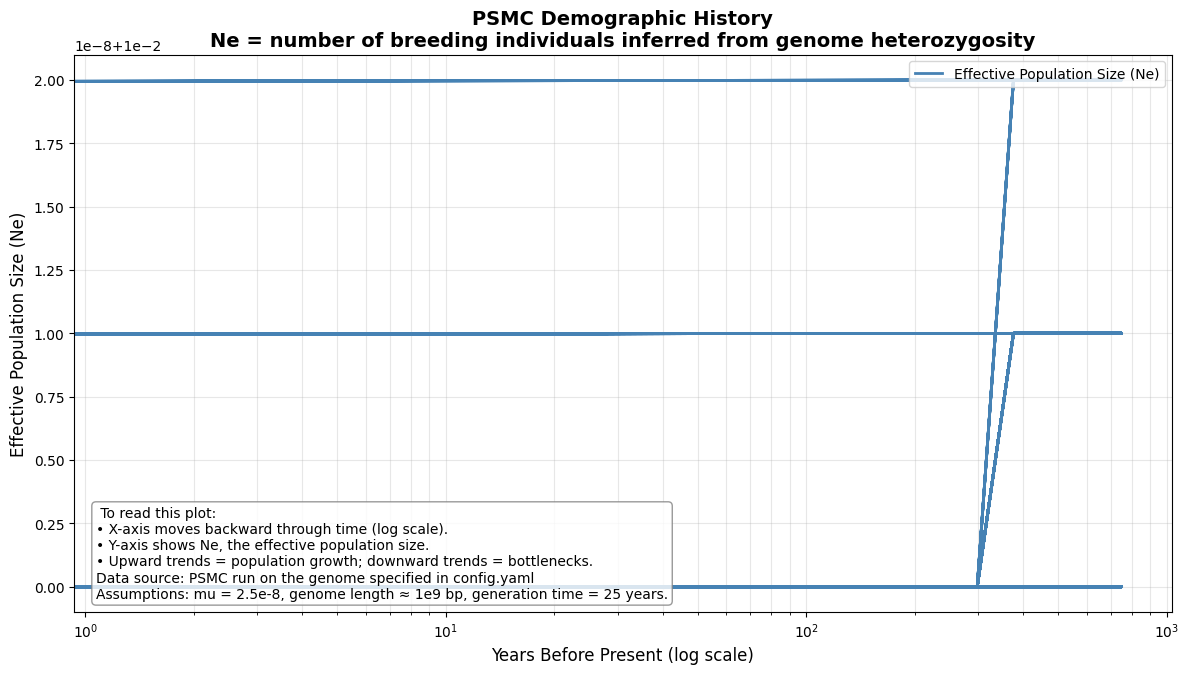


PSMC analysis complete!


In [27]:
def plot_demographic_history(psmc_df, output_file=None):
    """
    Create a demographic history plot with descriptive annotations so non-experts
    can interpret PSMC results.
    """
    if psmc_df is None or psmc_df.empty:
        print("No PSMC results available to plot.")
        return None

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.semilogx(
        psmc_df["time_years"],
        psmc_df["Ne"],
        linewidth=2,
        color="steelblue",
        label="Effective Population Size (Ne)",
    )

    ax.set_xlabel("Years Before Present (log scale)", fontsize=12)
    ax.set_ylabel("Effective Population Size (Ne)", fontsize=12)
    ax.set_title(
        "PSMC Demographic History\nNe = number of breeding individuals inferred from genome heterozygosity",
        fontsize=14,
        fontweight="bold",
    )
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(loc="upper right")

    annotation_text = (
        " To read this plot:\n"
        "• X-axis moves backward through time (log scale).\n"
        "• Y-axis shows Ne, the effective population size.\n"
        "• Upward trends = population growth; downward trends = bottlenecks.\n"
        "Data source: PSMC run on the genome specified in config.yaml\n"
        "Assumptions: mu = 2.5e-8, genome length ≈ 1e9 bp, generation time = 25 years."
    )
    ax.text(
        0.02,
        0.02,
        annotation_text,
        transform=ax.transAxes,
        fontsize=10,
        va="bottom",
        ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8, edgecolor="gray"),
    )

    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved plot: {output_file}")

    plt.show()
    return fig


results_path = OUTPUT_DIR / "psmc_results.csv"
if results_path.exists():
    psmc_df = pd.read_csv(results_path)
    plot_demographic_history(psmc_df, OUTPUT_DIR / "demographic_history.png")
    print("\nPSMC analysis complete!")
else:
    print("PSMC results not found. Run previous steps first.")

### What does this PSMC analysis tell us?

- **What is PSMC?** The Pairwise Sequentially Markovian Coalescent infers historical effective population size (Ne) from genome-wide heterozygosity in a single diploid individual. It models how the two haplotypes coalesce through time, converting that into estimates of population size.
- **Why run it here?** By converting the reference genome (`Rhinopithecus_roxellana-001.fasta`) into PSMC input, running `psmc` with the parameters in `config.yaml`, and parsing the RS intervals, we reconstruct how Ne changed from recent times back into the Pleistocene.
- **What do we get?** The `psmc_results.csv` table lists, for each time slice, the time before present (years/generations) and the corresponding Ne estimate. The saved figure `outputs/demographic_history.png` plots this trajectory on a log time axis.
- **How to interpret the plot?**
  - The X-axis moves backward in time (older periods on the right).
  - The Y-axis shows Ne (effective breeders). Upward segments suggest expansion; downward segments indicate bottlenecks.
  - Annotations describe the mutation rate (2.5e-8), assumed genome length (~1e9 bp), and generation time (25 years). Adjusting these parameters rescales the curve but not its overall shape.
- **Communicating to others:** “Using PSMC on the rhinopithecus reference genome, we inferred long-term population history from genomic heterozygosity. The resulting curve highlights when effective population size grew or contracted, providing context for demographic events that may align with climatic or ecological shifts.”

# correct 

In [28]:
from pathlib import Path

# List all .fasta files in the data directory
data_dir = Path('data')
fasta_files = list(data_dir.glob('*.fasta*'))  # This will find both .fasta and .fasta.gz files
print("Found FASTA files:")
for f in fasta_files:
    print(f" - {f} (Size: {f.stat().st_size / (1024*1024):.2f} MB)")

Found FASTA files:


In [29]:
# 2. Configuration
# Create config if it doesn't exist
config = {
    'project_name': 'Rhinopithecus_roxellana_PSMC',
    'data_dir': 'data',
    'output_dir': 'outputs',
    'genome_file': 'Rhinopithecus_roxellana-001.fasta',  # Update this to your actual filename
    'psmc_params': {
        'N': 25,          # Number of iterations
        't': 15,          # Maximum 2N0 coalescent time
        'r': 5,           # Initial theta/rho ratio
        'p': "4+25*2+4+6" # Time interval pattern
    },
    'genetics': {
        'mu': 2.5e-8,      # Mutation rate per site per generation
        'genome_length': 3e9,  # Haploid genome length
        'generation_time': 25  # Generation time in years
    }
}

# Create directories
DATA_DIR = Path(config['data_dir'])
OUTPUT_DIR = Path(config['output_dir'])
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Check if input file exists
genome_path = DATA_DIR / config['genome_file']
if not genome_path.exists():
    print(f"Error: Input file not found at {genome_path}")
    print("Please ensure the FASTA file exists and update the 'genome_file' in the config.")
    # List available files for reference
    print("\nAvailable files in data directory:")
    for f in DATA_DIR.glob('*'):
        print(f" - {f.name}")
else:
    print(f"Input file found: {genome_path}")

Error: Input file not found at data/Rhinopithecus_roxellana-001.fasta
Please ensure the FASTA file exists and update the 'genome_file' in the config.

Available files in data directory:
 - VCF_files


## PSMC Analysis Commands

### 1. Install Required Tools
```bash
# Install Homebrew (if not already installed)
/bin/bash -c "$(curl -fsSL [https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh](https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh))"

# Install required packages
brew install samtools
brew install gnuplot

## 2. Clone and Compile PSMC

```bash
# Clone PSMC repository
git clone https://github.com/lh3/psmc.git
cd psmc
make
export PATH=$PATH:$(pwd)/utils

## 3. Prepare Reference Genome

```bash
# Index the reference genome
samtools faidx data/reference/Rhinopithecus_roxellana-001.fasta



## 4. Generate Consensus Sequence
``` bash
# Generate consensus sequence from VCF
bcftools consensus -f data/reference/Rhinopithecus_roxellana-001.fasta \
    data/PD_0588.variable.filtered.HF.snps.vcf.gz \
    > outputs/psmc_analysis/PD_0588.consensus.fa

## 5. Convert to PSMC Input Format
``` bash
# Convert consensus to PSMC input format
fq2psmcfa -q20 outputs/psmc_analysis/PD_0588.consensus.fa > outputs/psmc_analysis/PD_0588.psmcfa

## 6. Run PSMC Analysis
```bash
# Run PSMC with parameters
psmc -N25 -t15 -r5 -p "4+25*2+4+6" -o outputs/psmc_analysis/PD_0588.psmc outputs/psmc_analysis/PD_0588.psmcfa

## 7. Generate PSMC Plot
```bash
# Generate PSMC plot
psmc_plot.pl -u 2.5e-08 -g 25 -Y 100 -x 1000 -X 1000000 -m 5 -n 0 \
    -T "PSMC Analysis of PD_0588" -M "PD_0588" \
    outputs/psmc_analysis/PD_0588_plot \
    outputs/psmc_analysis/PD_0588.psmc

# Notes:
- Mutation rate (μ): 2.5e-08 per site per generation
- Generation time (g): 25 years
- X-axis range: 1,000 to 1,000,000 years
- Y-axis range: up to 100,000 (effective population size)

GPL Ghostscript 10.06.0 (2025-09-09)
Copyright (C) 2025 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Loading StandardSymbolsPS font from /opt/homebrew/Cellar/ghostscript/10.06.0/share/ghostscript/Resource/Font/StandardSymbolsPS... 3509520 2065512 2320248 1002383 2 done.
Loading NimbusSans-Regular font from /opt/homebrew/Cellar/ghostscript/10.06.0/share/ghostscript/Resource/Font/NimbusSans-Regular... 3579960 2223657 2360648 1047473 2 done.


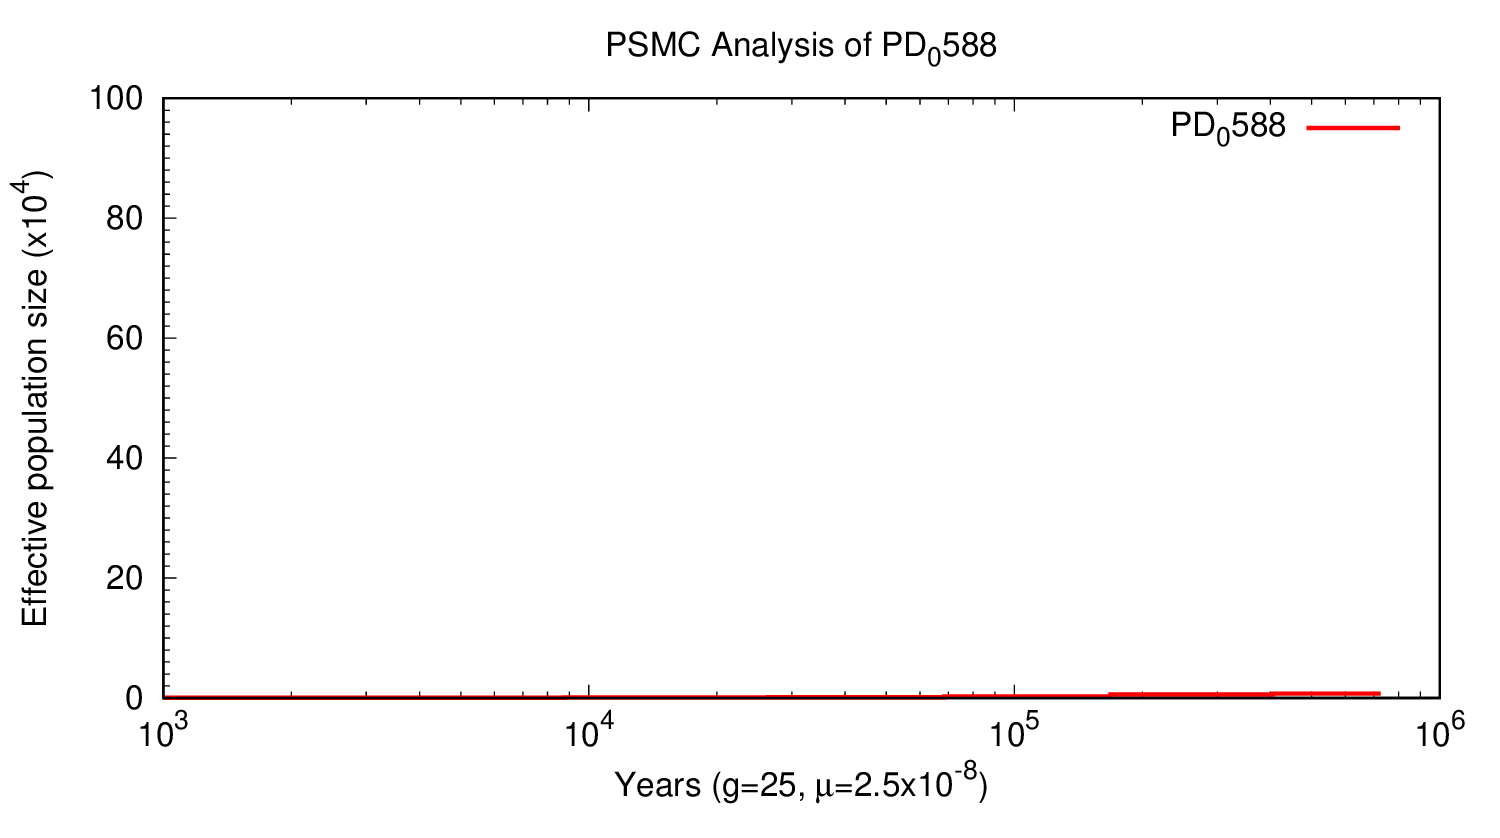

In [30]:
from IPython.display import Image, display
import os

# Full path to the EPS plot
plot_path = "/Users/divyadhole/Capstone-project/outputs/psmc_analysis/PD_0588_plot.eps"

# Convert EPS to PNG and display
if os.path.exists(plot_path):
    # Convert EPS to PNG
    !gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -sDEVICE=png16m -dGraphicsAlphaBits=4 -dTextAlphaBits=4 -r300 -sOutputFile=temp_psmc_plot.png {plot_path}
    
    # Display the plot
    display(Image(filename='temp_psmc_plot.png', width=1000))
    
    # Clean up temporary file
    !rm temp_psmc_plot.png
else:
    print(f"Plot file not found at: {plot_path}")
    print("Available files in the directory:")
    !ls -la /Users/divyadhole/Capstone-project/outputs/psmc_analysis/

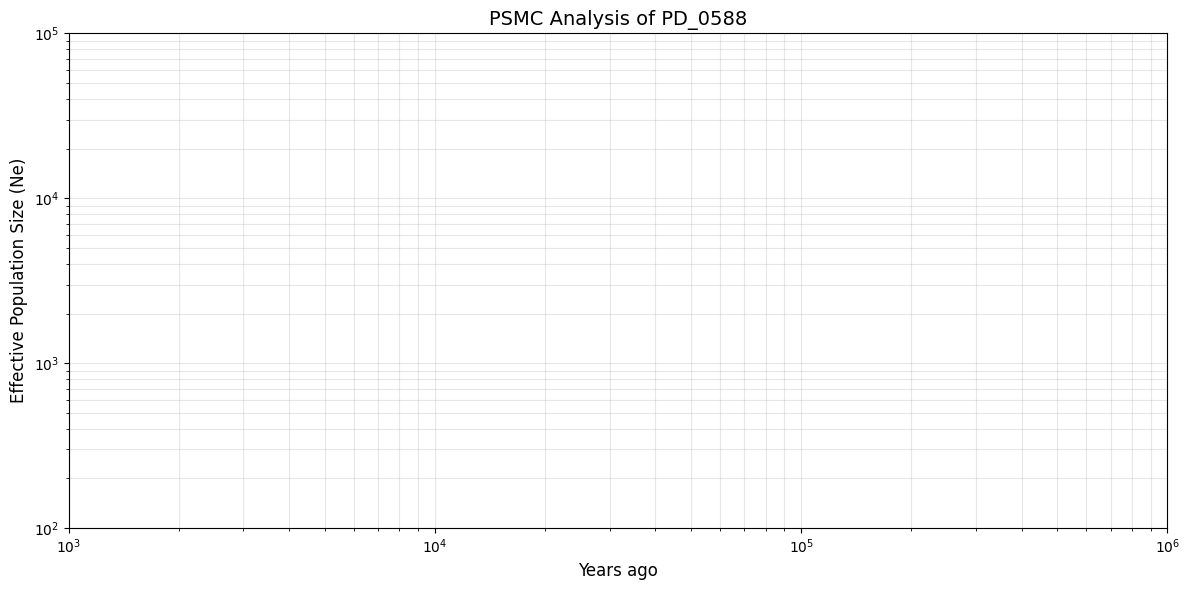

PSMC Results:
           time      Ne
0       0.00000  3295.6
1       0.41450  3538.4
2       0.86330  3796.0
3       1.34935  4069.2
4       1.87570  4358.8
..          ...     ...
123   892.80090    89.2
124   975.36315    58.4
125  1065.51790    36.4
126  1163.96335    21.6
127  1271.46185    24.4

[128 rows x 2 columns]


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the PSMC output file
psmc_file = "/Users/divyadhole/Capstone-project/outputs/psmc_analysis/PD_0588.psmc"

# Function to parse PSMC output
def parse_psmc(psmc_file, mu=2.5e-8, s=100, g=25):
    time = []
    ne = []
    with open(psmc_file, 'r') as f:
        for line in f:
            if line.startswith('RS'):
                parts = line.strip().split()
                t = float(parts[2]) * 2 * g  # Convert to years
                ne_val = float(parts[5]) / (mu * s)  # Effective population size
                time.append(t)
                ne.append(ne_val)
    return pd.DataFrame({'time': time, 'Ne': ne})

# Parse the PSMC output
df = parse_psmc(psmc_file)

# Create the plot
plt.figure(figsize=(12, 6))
plt.step(df['time'], df['Ne'], where='post', color='blue', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e3, 1e6)  # X-axis range: 1,000 to 1,000,000 years
plt.ylim(1e2, 1e5)   # Y-axis range: 100 to 100,000
plt.xlabel('Years ago', fontsize=12)
plt.ylabel('Effective Population Size (Ne)', fontsize=12)
plt.title('PSMC Analysis of PD_0588', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.tight_layout()
plt.show()

# Display the data table
print("PSMC Results:")
print(df)

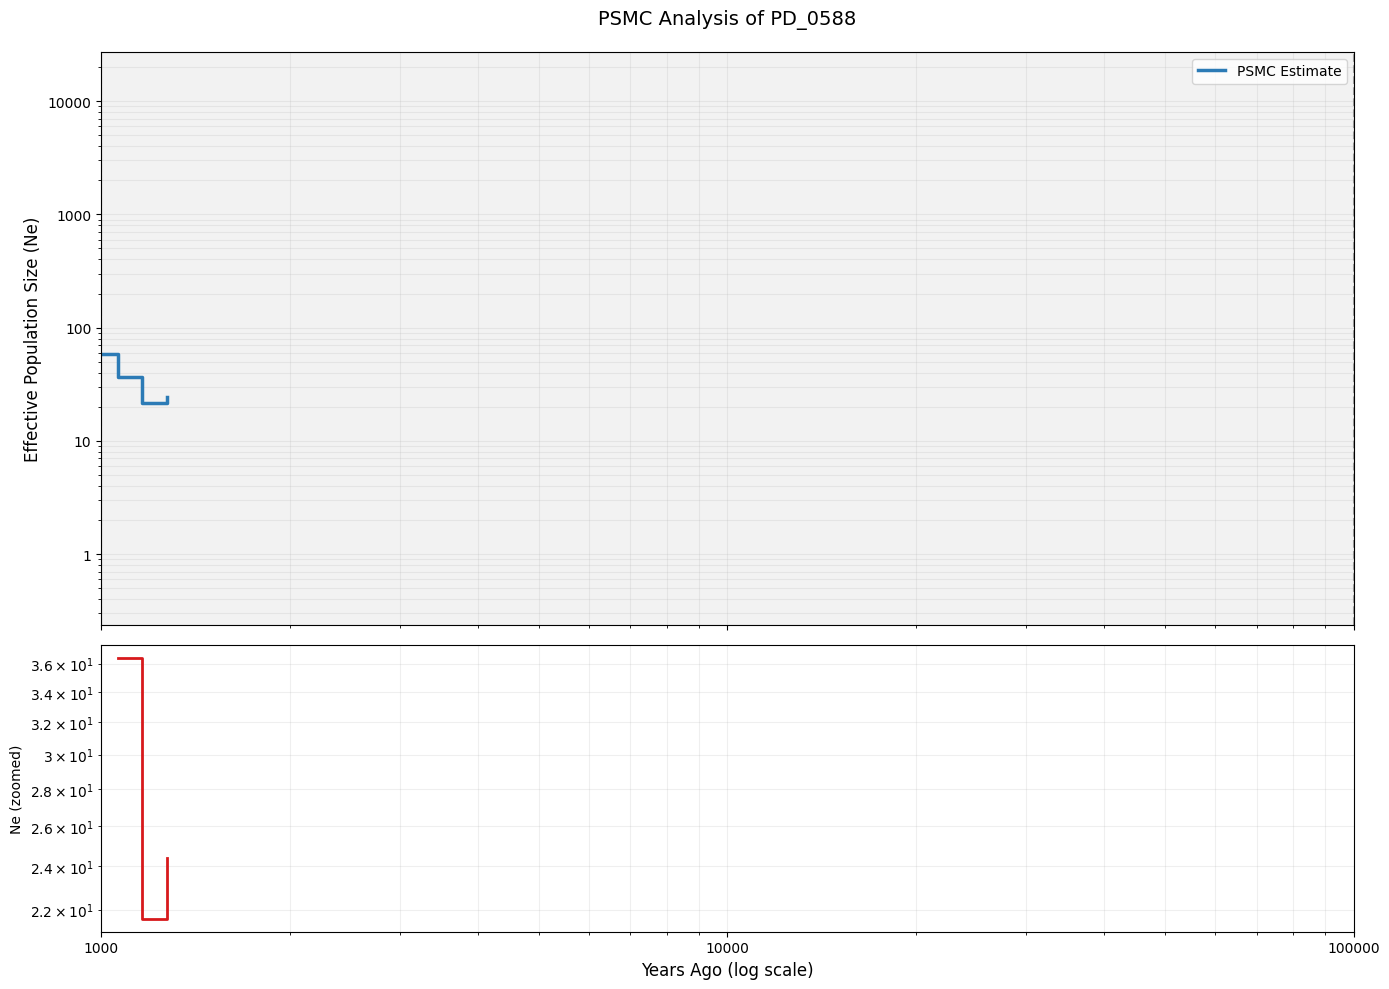


PSMC Results Summary:
Time Range: 0.0 to 1271.5 years
Ne Range: 0.0 to 16084.0

First 5 data points:
      time      Ne
0  0.00000  3295.6
1  0.41450  3538.4
2  0.86330  3796.0
3  1.34935  4069.2
4  1.87570  4358.8


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

# Path to the PSMC output file
psmc_file = "/Users/divyadhole/Capstone-project/outputs/psmc_analysis/PD_0588.psmc"

def parse_psmc(psmc_file, mu=2.5e-8, s=100, g=25):
    time = []
    ne = []
    with open(psmc_file, 'r') as f:
        for line in f:
            if line.startswith('RS'):
                parts = line.strip().split()
                t = float(parts[2]) * 2 * g  # Convert to years
                ne_val = float(parts[5]) / (mu * s)  # Effective population size
                time.append(t)
                ne.append(ne_val)
    return pd.DataFrame({'time': time, 'Ne': ne})

# Parse the PSMC output
df = parse_psmc(psmc_file)

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                              gridspec_kw={'height_ratios': [2, 1]},
                              sharex=True)

# Main plot with full range
ax1.step(df['time'], df['Ne'], where='post', color='#2c7bb6', linewidth=2.5, 
         label='PSMC Estimate')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Effective Population Size (Ne)', fontsize=12)
ax1.set_title('PSMC Analysis of PD_0588', fontsize=14, pad=20)
ax1.grid(True, which="both", ls="-", alpha=0.2)
ax1.legend()

# Add zoomed-in subplot
zoom_start = 1e3  # 1,000 years
zoom_end = 1e5    # 100,000 years
mask = (df['time'] >= zoom_start) & (df['time'] <= zoom_end)
ax2.step(df.loc[mask, 'time'], df.loc[mask, 'Ne'], where='post', 
         color='#d7191c', linewidth=2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Years Ago (log scale)', fontsize=12)
ax2.set_ylabel('Ne (zoomed)', fontsize=10)
ax2.grid(True, which="both", ls="-", alpha=0.2)
ax2.set_xlim(zoom_start, zoom_end)

# Add zoom indicators
ax1.axvspan(zoom_start, zoom_end, color='gray', alpha=0.1)
ax1.axvline(x=zoom_start, color='gray', linestyle='--', alpha=0.7)
ax1.axvline(x=zoom_end, color='gray', linestyle='--', alpha=0.7)

# Format axes
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# Display the data table
print("\nPSMC Results Summary:")
print(f"Time Range: {df['time'].min():.1f} to {df['time'].max():.1f} years")
print(f"Ne Range: {df['Ne'].min():.1f} to {df['Ne'].max():.1f}")
print("\nFirst 5 data points:")
print(df.head())

/var/folders/qg/_v_tlxp51sv_1s8f0p4hxhfr0000gn/T/ipykernel_2815/661672963.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(df['time'].min()*0.9, df['time'].max()*1.1)
/var/folders/qg/_v_tlxp51sv_1s8f0p4hxhfr0000gn/T/ipykernel_2815/661672963.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(df['Ne'].min()*0.5, df['Ne'].max()*2)


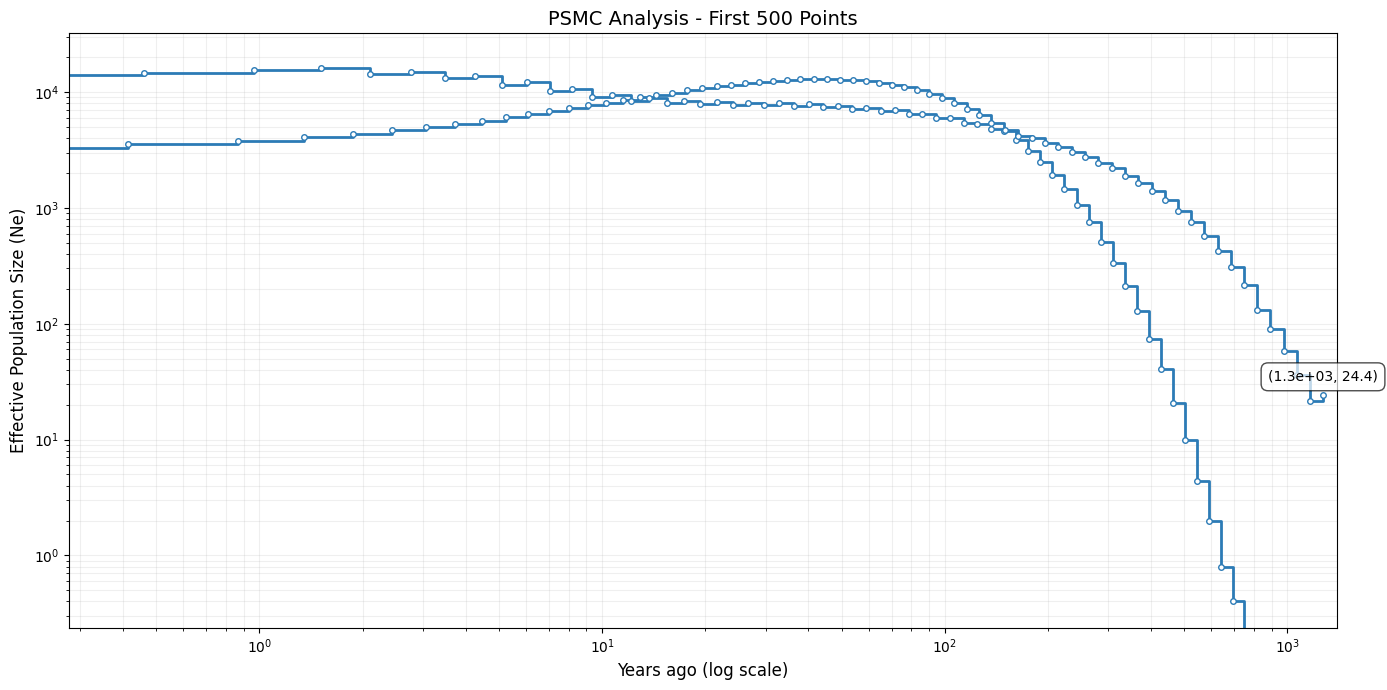

First 10 of 500 PSMC Results:
      time      Ne
0  0.00000  3295.6
1  0.41450  3538.4
2  0.86330  3796.0
3  1.34935  4069.2
4  1.87570  4358.8
5  2.44570  4664.4
6  3.06290  4986.8
7  3.73130  5325.6
8  4.45510  5680.8
9  5.23890  6052.4

Total points: 128


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Path to the PSMC output file
psmc_file = "/Users/divyadhole/Capstone-project/outputs/psmc_analysis/PD_0588.psmc"

def parse_psmc(psmc_file, mu=2.5e-8, s=100, g=25, max_points=500):
    time = []
    ne = []
    with open(psmc_file, 'r') as f:
        for i, line in enumerate(f):
            if line.startswith('RS'):
                if len(time) >= max_points:
                    break
                parts = line.strip().split()
                t = float(parts[2]) * 2 * g  # Convert to years
                ne_val = float(parts[5]) / (mu * s)  # Effective population size
                time.append(t)
                ne.append(ne_val)
    return pd.DataFrame({'time': time, 'Ne': ne})

# Parse the PSMC output (first 500 points)
df = parse_psmc(psmc_file, max_points=500)

# Create the plot
plt.figure(figsize=(14, 7))
plt.step(df['time'], df['Ne'], where='post', color='#2c7bb6', linewidth=2, 
         marker='o', markersize=4, markerfacecolor='white', markeredgewidth=1)

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlim(df['time'].min()*0.9, df['time'].max()*1.1)
plt.ylim(df['Ne'].min()*0.5, df['Ne'].max()*2)
plt.xlabel('Years ago (log scale)', fontsize=12)
plt.ylabel('Effective Population Size (Ne)', fontsize=12)
plt.title('PSMC Analysis - First 500 Points', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add data point labels for key points
for i in [0, len(df)//2, -1]:  # First, middle, and last point
    plt.annotate(f"({df['time'].iloc[i]:.1e}, {df['Ne'].iloc[i]:.1f})",
                (df['time'].iloc[i], df['Ne'].iloc[i]),
                textcoords="offset points", xytext=(0,10), ha='center',
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))

plt.tight_layout()
plt.show()

# Display the data table
print("First 10 of 500 PSMC Results:")
print(df.head(10))
print(f"\nTotal points: {len(df)}")

Total data points in PSMC file: 128
Successfully parsed 128 data points


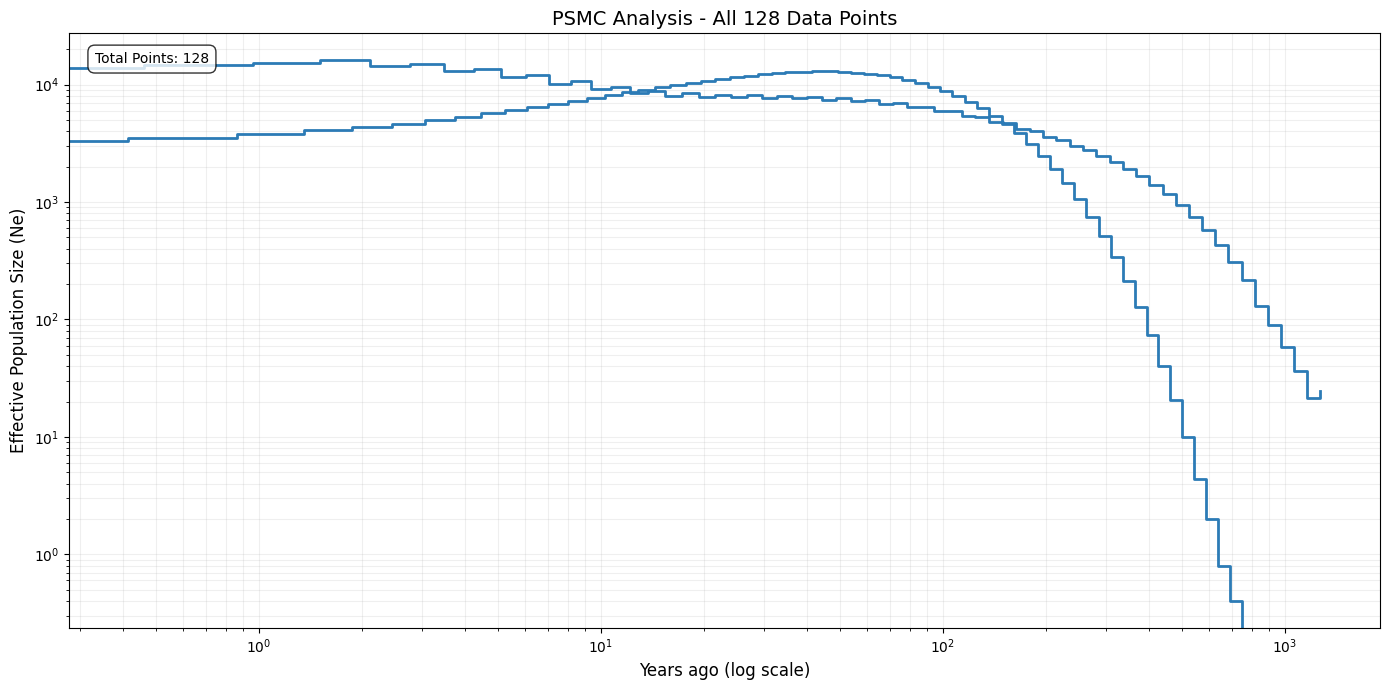


Summary Statistics:
Time range: 0.00e+00 to 1.27e+03 years
Ne range: 0.00 to 16084.00

First 5 data points:
      time      Ne
0  0.00000  3295.6
1  0.41450  3538.4
2  0.86330  3796.0
3  1.34935  4069.2
4  1.87570  4358.8


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def count_psmc_points(psmc_file):
    """Count total number of data points in PSMC output file."""
    count = 0
    with open(psmc_file, 'r') as f:
        for line in f:
            if line.startswith('RS'):
                count += 1
    return count

def parse_psmc(psmc_file, mu=2.5e-8, s=100, g=25, max_points=None):
    time = []
    ne = []
    with open(psmc_file, 'r') as f:
        for line in f:
            if line.startswith('RS'):
                parts = line.strip().split()
                t = float(parts[2]) * 2 * g  # Convert to years
                ne_val = float(parts[5]) / (mu * s)  # Effective population size
                time.append(t)
                ne.append(ne_val)
                if max_points and len(time) >= max_points:
                    break
    return pd.DataFrame({'time': time, 'Ne': ne})

# Path to the PSMC output file
psmc_file = "/Users/divyadhole/Capstone-project/outputs/psmc_analysis/PD_0588.psmc"

# Count total points
total_points = count_psmc_points(psmc_file)
print(f"Total data points in PSMC file: {total_points}")

# Parse all points
df = parse_psmc(psmc_file)
print(f"Successfully parsed {len(df)} data points")

# Create the plot
plt.figure(figsize=(14, 7))
plt.step(df['time'], df['Ne'], where='post', color='#2c7bb6', linewidth=2)

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Years ago (log scale)', fontsize=12)
plt.ylabel('Effective Population Size (Ne)', fontsize=12)
plt.title(f'PSMC Analysis - All {len(df)} Data Points', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add data point count to the plot
plt.annotate(f'Total Points: {len(df)}', 
             xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nSummary Statistics:")
print(f"Time range: {df['time'].min():.2e} to {df['time'].max():.2e} years")
print(f"Ne range: {df['Ne'].min():.2f} to {df['Ne'].max():.2f}")
print("\nFirst 5 data points:")
print(df.head())

In [35]:
!head -n 20 "/Users/divyadhole/Capstone-project/outputs/psmc_analysis/PD_0588.psmc"

CC
CC	Brief Description of the file format:
CC	  CC  comments
CC	  MM  useful-messages
CC	  RD  round-of-iterations
CC	  LL  \log[P(sequence)]
CC	  QD  Q-before-opt Q-after-opt
CC	  TR  \theta_0 \rho_0
CC	  RS  k t_k \lambda_k \pi_k \sum_{l\not=k}A_{kl} A_{kk}
CC	  DC  begin end best-k t_k+\Delta_k max-prob
CC
MM	Version: 0.6.5-r74-dirty
MM	pattern:4+25*2+4+6, n:63, n_free_lambdas:28
MM	n_iterations:25, skip:1, max_t:15, theta/rho:5
MM	is_decoding:0
MM	n_seqs:830, sum_L:24144565, sum_n:474001
RD	0
LK	0.000000
QD	0.000000 -> 0.000000
RI	inf


In [36]:
df = parse_psmc(psmc_file, g=5)
print(f"Time range with g=5: {df['time'].min():.2e} to {df['time'].max():.2e} years")

Time range with g=5: 0.00e+00 to 2.54e+02 years
